Import the necessary libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from enum import Enum
import math
import json

Section 1.0: Setup

In [34]:
class BasisFunctions(Enum):
    LINEAR = "linear"
    POLYNOMIAL = "polynomial"
    GAUSSIAN = "gaussian"
    SIGMOID = "sigmoid"

class GDMethods(Enum):
    GD = "gd"
    SGD = "sgd"
    ANALYTIC = "analytic"

class Linear_Regression:
    """
    Initializes Linear Regression model with configurable basis functions. Assumes 0 initial weights. Note that
    self.weights.shape = (num_features + 1,) due to bias being always linear.

    Args:
        X (numpy.ndarray): list of base, linear features (Nx1)
        y (numpy.ndarray): Targets (Nx1)
        basis_function (BasisFunctions): basis function that gets applied to each feature.
        num_features (int): number of features (if 0, will only have bias)
    """
    def __init__(self, X, y, num_features, basis_function: BasisFunctions):
        self.basis_function = basis_function
        self.num_features = num_features
        self.weights = np.zeros(self.num_features + 1)
        self.X = self.transform_X(X)
        self.y = y
    
    """
    Will transform the X design matrix into a transformed design matrix (capital Phi) by applying the corresponding basis function.
    Returns an N x (num_features + 1) design matrix where the (num_features) rightmost columns have the basis function applied.
    """
    def transform_X(self, X):
        X = X.reshape(-1, 1)
        N = X.shape[0]

        temp = np.ones((N, 1)).reshape(-1, 1)
        match self.basis_function:
            case BasisFunctions.LINEAR: 
                for i in range (1, self.num_features + 1):
                    temp = np.hstack((temp, X))
            case BasisFunctions.POLYNOMIAL:
                for i in range (1, self.num_features + 1):
                    temp = np.hstack((temp, X ** i))
            case BasisFunctions.GAUSSIAN:
                X_max = np.max(X)
                X_min = np.min(X)
                for i in range (1, self.num_features + 1):
                    mean = X_min + (X_max - X_min) * (i - 1) / (self.num_features - 1)
                    exponent = -((X - mean)**2)
                    gaussian = np.exp(exponent)
                    temp = np.hstack((temp, gaussian))
            case BasisFunctions.SIGMOID:
                X_max = np.max(X)
                X_min = np.min(X)
                for i in range (1, self.num_features + 1):
                    mean = X_min + (X_max - X_min) * (i - 1) / (self.num_features - 1)
                    exponent = -(X - mean)
                    sigmoid = 1 / (1 + np.exp(exponent))
                    temp = np.hstack((temp, sigmoid))
        return temp    

    def reset_model(self):
        self.weights = np.zeros(self.num_features + 1)
    
    def plot_bases(self):
        pass

    def plot_model(self, X_data, y_data, show_bases=True, show_true_function=False, **kwargs):
        w = np.asarray(self.weights).reshape(-1)

        x_dense = np.linspace(X_data.min(), X_data.max(), 1000)

        Phi_dense = self.transform_X(x_dense)
        y_hat = Phi_dense @ w

        plt.figure(figsize=(8, 4.5))
        plt.scatter(X_data, y_data, s=18, alpha=0.75, label="data", color="blue")

        if show_bases:
            # Plot each weighted basis (skip bias column 0)
            for j in range(Phi_dense.shape[1]):
                plt.plot(x_dense, w[j] * Phi_dense[:, j], linewidth=0.8, alpha=0.4)

        if show_true_function and kwargs.get("true_function"):
            true_function = kwargs.get("true_function")
            plt.plot(x_dense, true_function(x_dense), alpha=0.75, label="true function", color="green")

        plt.plot(x_dense, y_hat, linewidth=2.5, label="model", color="red")
        plt.ylim(bottom=np.min(self.y) - 0.5, top=np.max(self.y) + 0.5)
        plt.title(kwargs.get("title") if not None else f"Linear Regression with {self.basis_function.value.capitalize()} bases")
        plt.legend()
        plt.tight_layout()
        plt.show()

    """
    Fits the linear regression model depending on GD method. Different arguments are required depending on method.
    kwargs contains: "epoch", "learning_rate", "print_vals", "regularization_strength"
    """
    def fit(self, method: GDMethods, **kwargs):
        do_print_vals = kwargs.get("print_vals")
        regularization_strength = kwargs.get("regularization_strength")
        if regularization_strength is None:
            regularization_strength = 0
        match method:
            case GDMethods.ANALYTIC:
                self.weights = np.linalg.pinv(self.X.T @ self.X) @ self.X.T @ self.y
            case GDMethods.SGD:
                lr = float(kwargs.get("learning_rate"))
                for epoch in range(1, int(kwargs.get("epoch")) + 1):
                    epoch_loss = np.sum((self.X @ self.weights - self.y)**2) / self.X.shape[0]
                    if do_print_vals is not None and do_print_vals:
                        print(f"Epoch {epoch - 1} SSE: {epoch_loss}")
                    for (x, y) in zip(self.X, self.y):
                        grad = x * (self.weights.T @ x - y)
                        self.weights -= lr * grad / grad.shape[0] + lr * (regularization_strength * self.weights)
                
                final_loss = np.sum((self.X @ self.weights - self.y)**2) / self.X.shape[0]
                if do_print_vals is not None and do_print_vals:
                    print(f"Final SSE: {final_loss}")
            case GDMethods.GD:
                lr = float(kwargs.get("learning_rate"))
                for epoch in range(1, int(kwargs.get("epoch")) + 1):
                    epoch_loss = np.sum((self.X @ self.weights - self.y)**2) / self.X.shape[0]
                    if do_print_vals is not None and do_print_vals:
                        print(f"Epoch {epoch - 1} SSE: {epoch_loss}")
                    
                    grad = self.X.T @ (self.X @ self.weights - self.y) / self.X.shape[0]
                    self.weights -= lr * (grad + (regularization_strength * self.weights)) 
                
                final_loss = np.sum((self.X @ self.weights - self.y)**2) / self.X.shape[0]
                if do_print_vals is not None and do_print_vals:
                    print(f"Final SSE: {final_loss}")


    """
    Samples one value from a given function while adding Gaussian noise.

    Args:
        x (float): Input to function
        function (Callable(float, float)): Function to be sampled from.
        std (float): Standard deviation
        seed (int): Defaulted to None, but used for consistent sampling
    
    Returns:
        float: Sampled value from function
    """
    @staticmethod
    def gaussian_noise_sampling(x, function, std=1, seed=None, section_4=False):
        gaussian_sample = np.random.default_rng(seed=seed).normal(loc=0, scale=std, size=1)
        if not section_4:
            return function(x) + gaussian_sample
        else:
            return function(x) + 2 * gaussian_sample

    @staticmethod
    def sampler(function, sample_size, x_start, x_end, std=1, seed=None, random=False, section_4=False):
        if random:
            x_values = np.random.default_rng().uniform(low=x_start, high=x_end, size=sample_size)
        else:
            x_values = np.linspace(x_start, x_end, sample_size)
        
        y_values = []
        for i in range(sample_size):
            y_values.append(Linear_Regression.gaussian_noise_sampling(x_values[i], function, std, seed, section_4=True if section_4 else False)[0])
        
        y_values = np.array(y_values)

        return {"x": x_values, "y": y_values}
    
    @staticmethod
    def assignment_function(x):
        return (np.log(x) + 1) * np.cos(x) + np.sin(2 * x)

    @staticmethod
    def random_test_function(x):
        return x * np.cos(x) + x * x

    @staticmethod
    def assignment_function_section_4(x):
        return -3 * x + 8
    
    # Will use entire dataset to split into folds. (No need for test subset)
    @staticmethod
    def cross_validation_10_fold(X, y):
        X_folds = np.array_split(X, 10)
        y_folds = np.array_split(y, 10)

        # { train_err: float, std: float }
        train_results = {}
        # { val_err: float, std: float}
        val_results = {}

        # 10 diff hyperparam (#features) values (0, 5, ..., 40, 45)
        for i in range(10):
            
            # the actual 10-fold CV for one hyperparam value
            temp_train_err = []
            temp_val_err = []
            for j in range(10):
                training_X = np.hstack([X_folds[k] for k in range(10) if k != j])
                training_y = np.hstack([y_folds[k] for k in range(10) if k != j])

                model = Linear_Regression(training_X, training_y, num_features=i*5, basis_function=BasisFunctions.GAUSSIAN)
                model.fit(GDMethods.GD, epoch=60, learning_rate=0.2, print_vals=False)
                temp_train_err.append(np.sum((model.X @ model.weights - training_y)**2) / training_X.shape[0])

                validating_X = X_folds[j]
                transformed_validating_X = model.transform_X(validating_X)
                validating_y = y_folds[j]
                temp_val_err.append(np.sum((transformed_validating_X @ model.weights - validating_y)**2) / transformed_validating_X.shape[0])
        
            train_results[f"{i * 5} Gaussian Bases"] = { "train_err": np.mean(temp_train_err), "std": np.std(temp_train_err) }
            val_results[f"{i * 5} Gaussian Bases"] = { "val_err": np.mean(temp_val_err), "std": np.std(temp_val_err) }
        
        return train_results, val_results




Section 1.1: Mock data

(np.float64(1.0680065835339838), np.float64(2.346183355498555)) (np.float64(1.347000286253503), np.float64(-0.3593280154147014)) (np.float64(1.5955019975323939), np.float64(0.06607535662555675)) (np.float64(1.6097792368316055), np.float64(-1.0715563314043566)) (np.float64(1.8162123728556945), np.float64(-1.3183711097268098)) (np.float64(1.9383945070598239), np.float64(-1.7508375429889254)) (np.float64(2.019842940088467), np.float64(-0.10246717152240792)) (np.float64(2.1560612943442257), np.float64(-0.09863733208720671)) (np.float64(2.272721028352072), np.float64(-3.866336133338315)) (np.float64(2.3597624352852584), np.float64(-2.6354439755646473)) (np.float64(2.3699017211831537), np.float64(-1.4080487644540165)) (np.float64(2.537145287124905), np.float64(-2.747250040897457)) (np.float64(2.60071928038555), np.float64(-4.314908511442756)) (np.float64(2.647351544320707), np.float64(-3.3390082383144923)) (np.float64(2.7944211932500846), np.float64(-1.9814152238318887)) (np.float64(2.833011

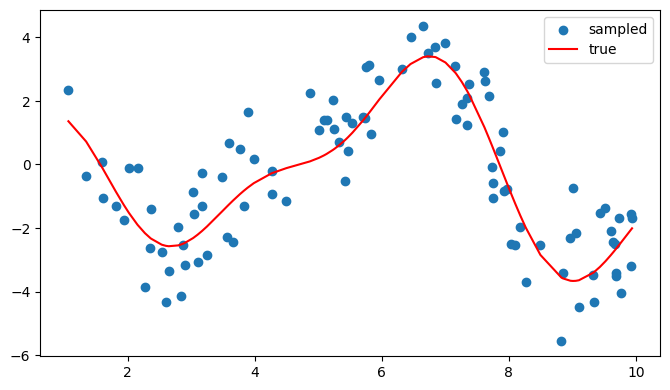

In [83]:
data = Linear_Regression.sampler(Linear_Regression.assignment_function, 100, 1, 10, random=True)
x = data.get("x")
y = data.get("y")

x_plot, y_plot = zip(*sorted(zip(x, y)))
x_plot = np.array(x_plot)
y_plot = np.array(y_plot)

print(*zip(x_plot, y_plot))

plt.figure(figsize=(8, 4.5))
plt.scatter(x_plot, y_plot, label="sampled")
plt.plot(x_plot, Linear_Regression.assignment_function(x_plot), label="true", color='red')
plt.legend()
plt.show()

Section 1.2/1.3: Fitting with various amounts of basis functions

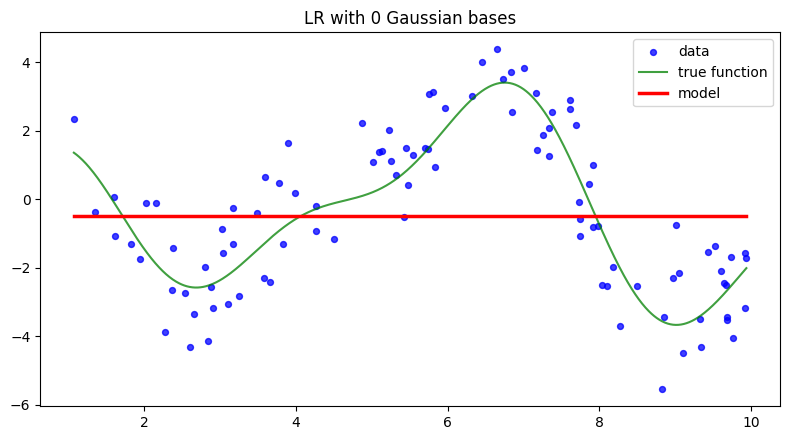

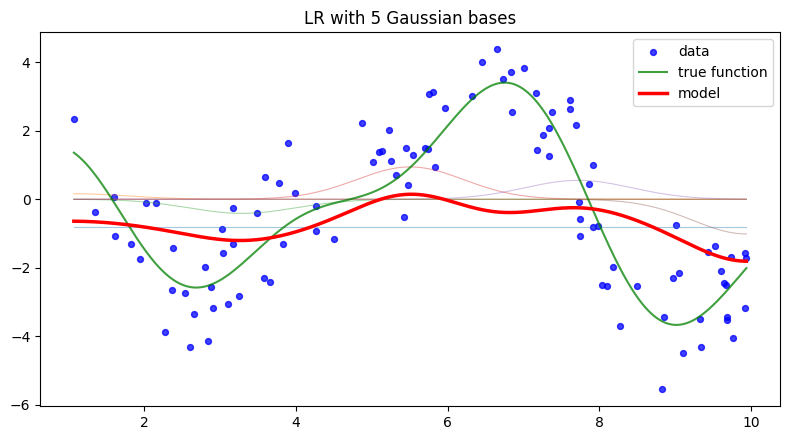

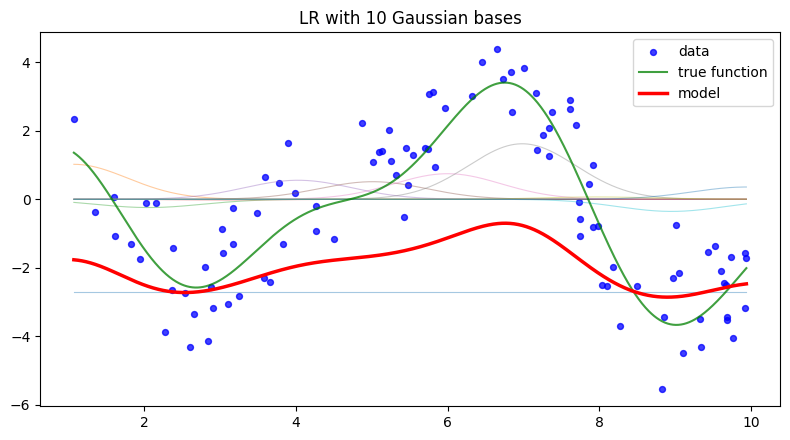

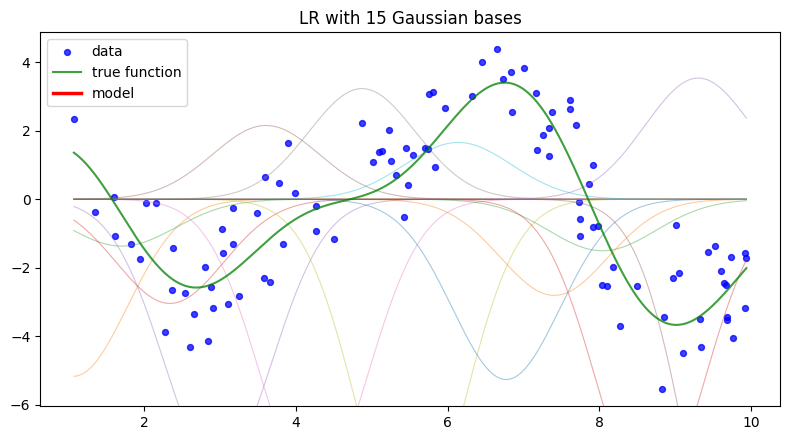

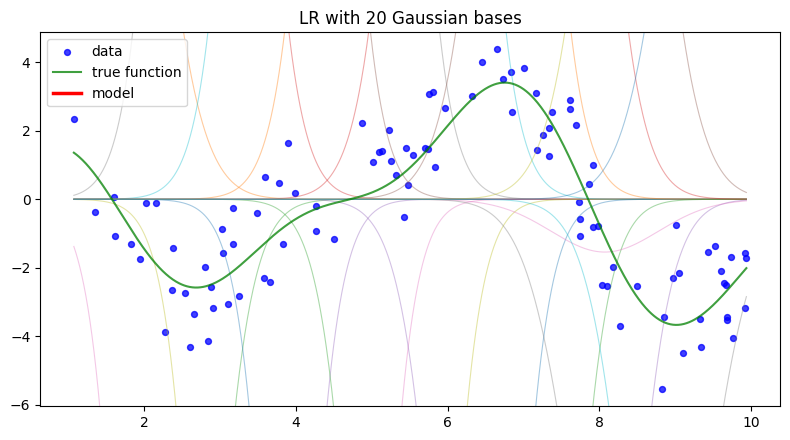

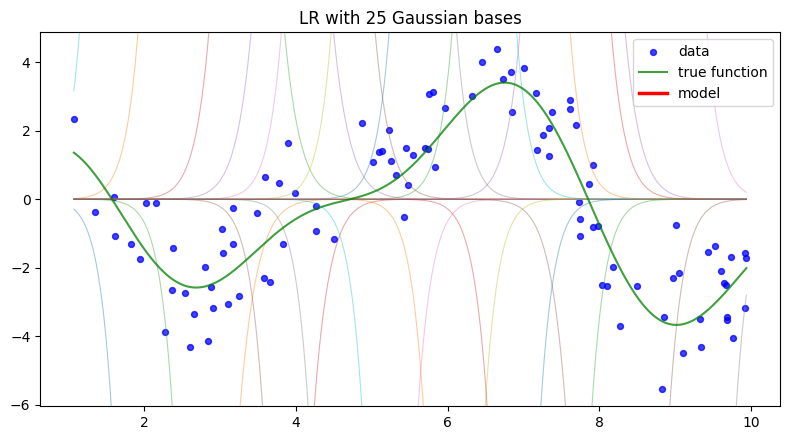

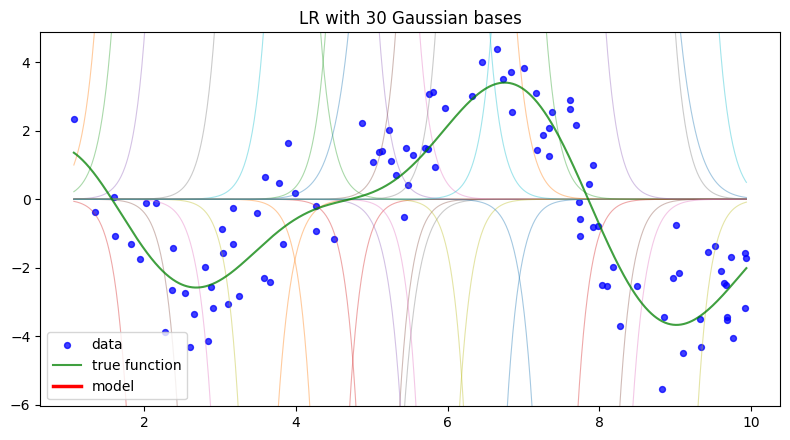

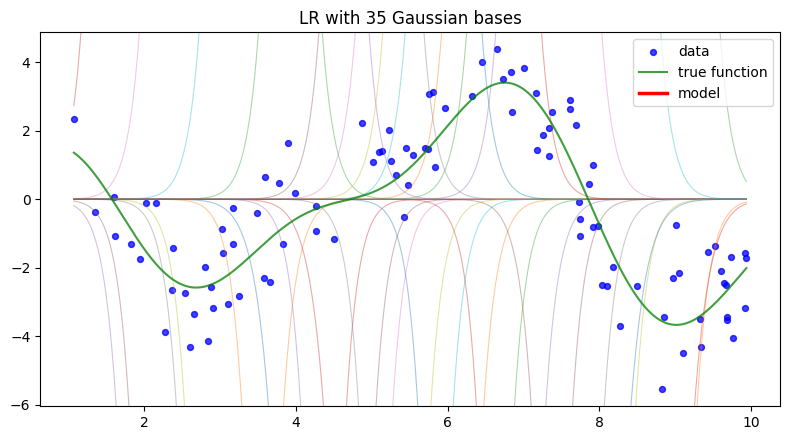

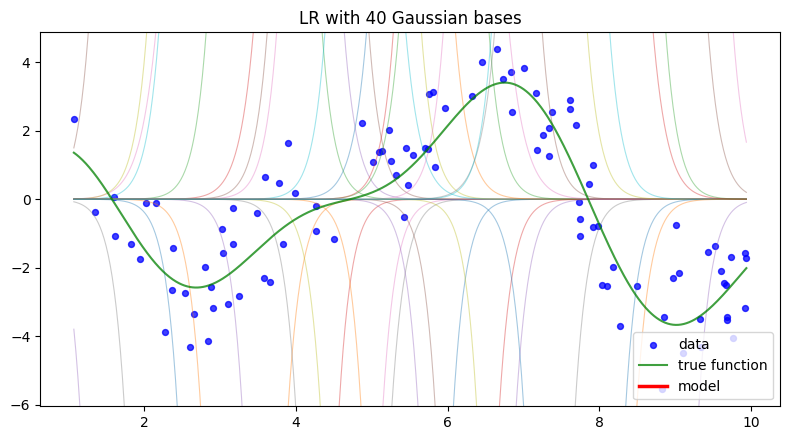

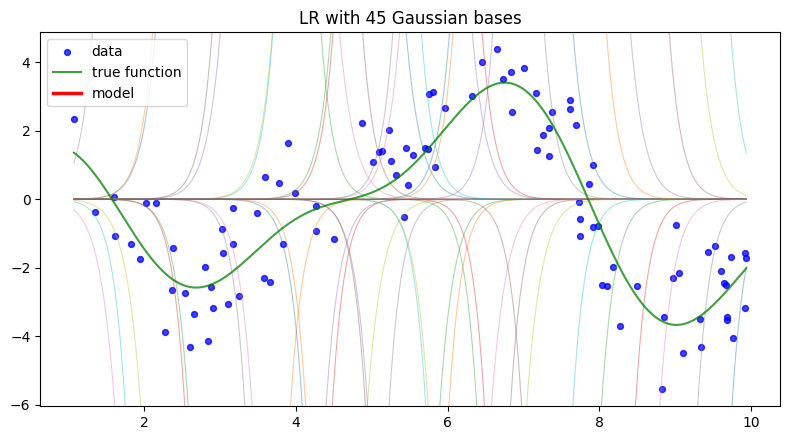

In [84]:
for i in range(10):
    model = Linear_Regression(x, y, num_features=i*5, basis_function=BasisFunctions.GAUSSIAN)
    model.fit(GDMethods.ANALYTIC)
    model.plot_model(x, y, show_bases=True, show_true_function=True, true_function=Linear_Regression.assignment_function, title=f"LR with {i*5} Gaussian bases")

Section 1.4: 10-fold Cross-Validation for #basis selection

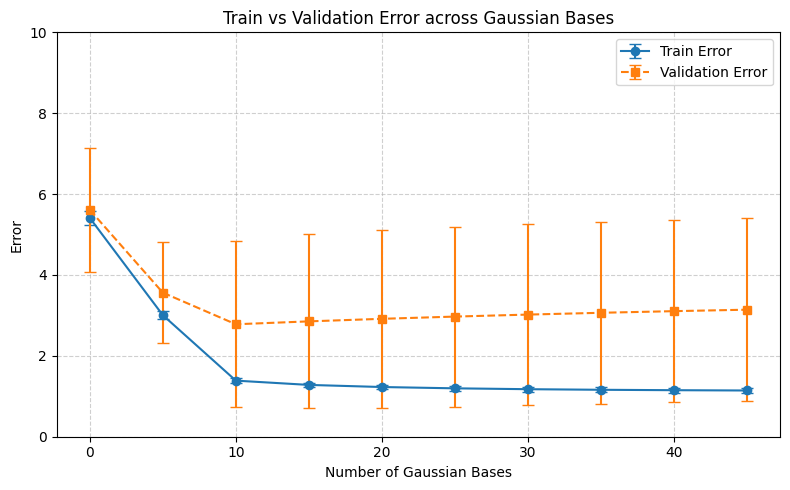

In [88]:
train_results, val_results = Linear_Regression.cross_validation_10_fold(x, y)

# --- Extract data ---
bases = [int(k.split()[0]) for k in train_results.keys()]
train_err = [v["train_err"] for v in train_results.values()]
train_std = [v["std"] for v in train_results.values()]
val_err = [v["val_err"] for v in val_results.values()]
val_std = [v["std"] for v in val_results.values()]

# --- Plot ---
plt.figure(figsize=(8,5))

plt.errorbar(
    bases, train_err, yerr=train_std,
    fmt='o-', capsize=4, label='Train Error', color='tab:blue'
)
plt.errorbar(
    bases, val_err, yerr=val_std,
    fmt='s--', capsize=4, label='Validation Error', color='tab:orange'
)

plt.title("Train vs Validation Error across Gaussian Bases")
plt.xlabel("Number of Gaussian Bases")
plt.ylabel("Error")
plt.ylim(0, 10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

We can see that 5 is the optimal number of Gaussian bases, even if 10 has the lowest Validation Error. This is because the validation error for 5 bases fits within 1 std of 10 bases' validation error and it is a "simpler" model than the one with 10 bases.
On another note, we can observe the transition from underfitting to overfitting by strictly looking at the validation curve. We can see that the model improves in validation error as you increase the number of bases from 0 to 10, which is also around which you observe underfitting (as the model can get better still), but starts to increase from there. This indicates that from 10 Gaussian bases, the model suffers from too much variance, thus hurting its validation performance, even if the training error consistently decreases.

Section 2.1: Regenerating data

In [90]:
generated_repetitions = []
for i in range(10):
    generated_repetitions.append(Linear_Regression.sampler(Linear_Regression.assignment_function, 100, 1, 10, random=True))

Section 2.2/2.3/2.4: Plotting fitted models and observing the Bias-Variance tradeoff

In [20]:
models = []
for i in range(10):
    dataset = generated_repetitions[i]
    x = dataset.get("x")
    y = dataset.get("y")
    
    model = Linear_Regression(x, y, num_features=i * 5, basis_function=BasisFunctions.GAUSSIAN)
    model.fit(GDMethods.GD, epoch = 60, learning_rate=0.2, print_vals=False)
    models.append(model)

def predict_with(model, x):
    if hasattr(model, "predict"):
        return model.predict(x)
    elif hasattr(model, "transform_X"):
        return model.transform_X(x) @ model.weights
    raise AttributeError("Model needs predict(x) or transform_X(x)")

# ---- domain for plotting (set to your data’s domain if you have it) ----
xmin, xmax = 0.2, 8.0   # avoid log(0); change if your data range is known
x = np.linspace(xmin, xmax, 400)

# ---- true function ----
true_vals = Linear_Regression.assignment_function(x)

# ---- predictions ----
preds = [predict_with(m, x) for m in models]      # list of (len(x),)
preds = np.vstack(preds)                           # (10, len(x))
avg_pred = preds.mean(axis=0)

# ---- plot ----
plt.figure(figsize=(9,5))

# all models: thin, transparent green
for yhat in preds:
    plt.plot(x, yhat, linewidth=1, alpha=0.25, color='green')

# average: red
plt.plot(x, avg_pred, linewidth=2.5, color='red', label='Average model')

# true: black dashed
plt.plot(x, true_vals, 'k--', linewidth=2, label='True function')

# legend with proxy for the stack of green lines
models_proxy = mlines.Line2D([], [], color='green', alpha=0.25, linewidth=1, label='Individual models')
plt.legend(handles=[models_proxy] + plt.gca().lines[-2:], loc='best')

plt.title('Gaussian-basis Linear Regression: 10 models, average, and true function')
plt.xlabel('x'); plt.ylabel('y')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

NameError: name 'generated_repetitions' is not defined

Section 4.1: Generating data

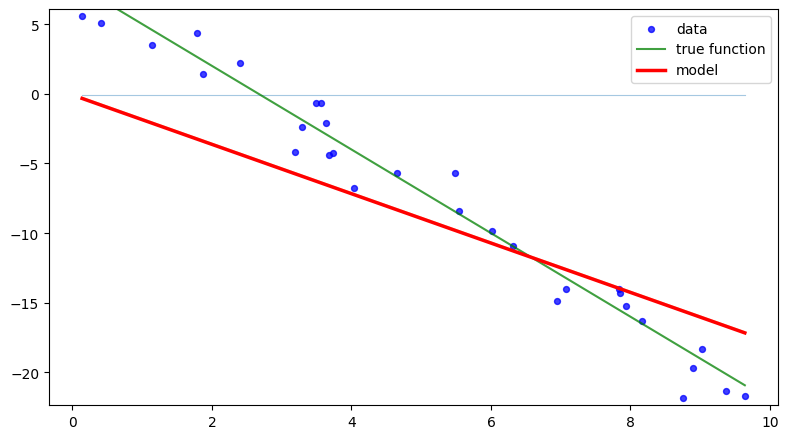

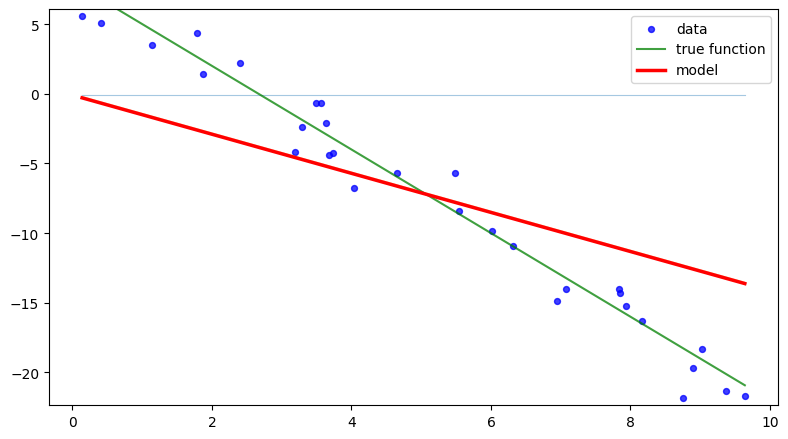

In [57]:
data = Linear_Regression.sampler(Linear_Regression.assignment_function_section_4, 30, 0, 10, random=True, section_4=True)
x = data.get("x")
y = data.get("y")

model_no_reg = Linear_Regression(x, y, num_features=1, basis_function=BasisFunctions.LINEAR)
model_reg = Linear_Regression(x, y, num_features=1, basis_function=BasisFunctions.LINEAR)

model_no_reg.fit(GDMethods.GD, epoch=100, learning_rate=0.001)
model_reg.fit(GDMethods.GD, epoch=100, learning_rate=0.001, regularization_strength=10)

model_no_reg.plot_model(x, y, show_bases=True, show_true_function=True, true_function=Linear_Regression.assignment_function_section_4)
model_reg.plot_model(x, y, show_bases=True, show_true_function=True, true_function=Linear_Regression.assignment_function_section_4)